In [1]:
import pandas as pd
import numpy as np
import os

# data visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# preprocessing text
import nltk
import re
import ssl
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# train test split
from sklearn.model_selection import train_test_split

# feature engineering
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec
from sentence_transformers import SentenceTransformer
from scipy.stats import chi2_contingency, ttest_ind
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import VarianceThreshold

# modelling
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

/Users/geraldho/Desktop/BT4012/Project/Fraud-Email/.venv/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


## Reading Data

In [2]:
df = pd.read_csv("./data/Phish_No_More.csv")
df.shape

(39154, 7)

In [3]:
SEED = 42

In [4]:
df.head()

,sender,receiver,date,subject,body,label,urls
0,Young Esposito <Young@iworld.de>,user4@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 16:31:02 -0700",Never agree to be a loser,"Buck up, your troubles caused by small dimensi...",1,1
1,Mok <ipline's1983@icable.ph>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 18:31:03 -0500",Befriend Jenna Jameson,\nUpgrade your sex and pleasures with these te...,1,1
2,Daily Top 10 <Karmandeep-opengevl@universalnet...,user2.9@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 20:28:00 -1200",CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1,1
3,Michael Parker <ivqrnai@pobox.com>,SpamAssassin Dev <xrh@spamassassin.apache.org>,"Tue, 05 Aug 2008 17:31:20 -0600",Re: svn commit: r619753 - in /spamassassin/tru...,Would anyone object to removing .so from this ...,0,1
4,Gretchen Suggs <externalsep1@loanofficertool.com>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 19:31:21 -0400",SpecialPricesPharmMoreinfo,\nWelcomeFastShippingCustomerSupport\nhttp://7...,1,1


## Cleaning the Data

In [5]:
# Splitting 'sender' into 'name' and 'email'
df[["sender_name", "sender_email"]] = df["sender"].str.extract(
    r"(?P<name>.+?)\s*<(?P<email>.+?)>"
)

# Use the 'str.extract' method to create two new columns based on the pattern
df[["receiver_name", "receiver_email"]] = df["receiver"].str.extract(
    r"(?:(?P<receiver_name>.*)\s<)?(?P<receiver_email>[^<>]+)>?"
)

# Extracting the domain from 'sender_email'
df["sender_domain"] = df["sender_email"].str.extract(r"@(.+)", expand=False)

# Extracting the domain from 'receiver_email'
df["receiver_domain"] = df["receiver_email"].str.extract(r"@(.+)", expand=False)

In [6]:
# Converting 'date' to datetime format and forcing invalid formats to NaT
df["date"] = pd.to_datetime(df["date"], errors="coerce", utc=True)

# Dropping rows where 'date' is NaT (i.e., invalid datetime entries)
df = df.dropna(subset=["date"])

# Extracting year, month, day, hour from the 'date' column
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month
df["day"] = df["date"].dt.day
df["hour"] = df["date"].dt.hour

In [7]:
# Renaming 'urls' column to 'body_contains_url'
df.rename(columns={"urls": "body_contains_url"}, inplace=True)

# Renaming 'label' column to 'is_fraud_email'
df.rename(columns={"label": "is_fraud_email"}, inplace=True)

In [8]:
# Check for null values in the DataFrame
null_summary = df.isnull().sum()

# Display the columns with null values
print("Columns with null values:\n", null_summary[null_summary > 0])

Columns with null values:
 receiver             462
subject               28
sender_name         3454
sender_email        3454
receiver_name      32048
receiver_email       462
sender_domain       3456
receiver_domain      558
dtype: int64


In [9]:
# Drop rows where 'receiver', 'subject', or 'receiver_email' are null
df = df.dropna(subset=["receiver", "subject", "receiver_email"])

# Drop the 'receiver_name' column entirely due to high percentage of missing values
df = df.drop(columns=["receiver_name"])

# Drop rows where both 'sender_name' and 'sender_email' are null
df = df.dropna(subset=["sender_name", "sender_email"], how="all")

# Optionally, drop rows where 'sender_domain' and 'receiver_domain' are null if domain analysis is important
df = df.dropna(subset=["sender_domain", "receiver_domain"], how="any")

In [10]:
# Drop the specified columns
df = df.drop(columns=["sender", "receiver"])

In [11]:
# Final df shape
df.shape

(35286, 14)

In [12]:
df.head()

,date,subject,body,is_fraud_email,body_contains_url,sender_name,sender_email,receiver_email,sender_domain,receiver_domain,year,month,day,hour
0,2008-08-05 23:31:02+00:00,Never agree to be a loser,"Buck up, your troubles caused by small dimensi...",1,1,Young Esposito,Young@iworld.de,user4@gvc.ceas-challenge.cc,iworld.de,gvc.ceas-challenge.cc,2008,8,5,23
1,2008-08-05 23:31:03+00:00,Befriend Jenna Jameson,\nUpgrade your sex and pleasures with these te...,1,1,Mok,ipline's1983@icable.ph,user2.2@gvc.ceas-challenge.cc,icable.ph,gvc.ceas-challenge.cc,2008,8,5,23
2,2008-08-06 08:28:00+00:00,CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1,1,Daily Top 10,Karmandeep-opengevl@universalnet.psi.br,user2.9@gvc.ceas-challenge.cc,universalnet.psi.br,gvc.ceas-challenge.cc,2008,8,6,8
3,2008-08-05 23:31:20+00:00,Re: svn commit: r619753 - in /spamassassin/tru...,Would anyone object to removing .so from this ...,0,1,Michael Parker,ivqrnai@pobox.com,xrh@spamassassin.apache.org,pobox.com,spamassassin.apache.org,2008,8,5,23
4,2008-08-05 23:31:21+00:00,SpecialPricesPharmMoreinfo,\nWelcomeFastShippingCustomerSupport\nhttp://7...,1,1,Gretchen Suggs,externalsep1@loanofficertool.com,user2.2@gvc.ceas-challenge.cc,loanofficertool.com,gvc.ceas-challenge.cc,2008,8,5,23


In [13]:
df.isnull().sum()

date                 0
subject              0
body                 0
is_fraud_email       0
body_contains_url    0
sender_name          0
sender_email         0
receiver_email       0
sender_domain        0
receiver_domain      0
year                 0
month                0
day                  0
hour                 0
dtype: int64

In [14]:
df.reset_index(drop=True, inplace=True)

## Visualising Legit vs Phishing Email Counts

In [15]:
# Get counts of each 'Email Type'
email_type_counts = df["is_fraud_email"].value_counts().reset_index()

# Rename columns for clarity
email_type_counts.columns = ["Email Type", "Count"]

# Calculate total count of emails
total_count = email_type_counts["Count"].sum()

# Calculate percentages and round off to 1 decimal place
email_type_counts["Percentage"] = (
    (email_type_counts["Count"] / total_count) * 100
).round(1)

# Display percentages as numeric with '%' symbol attached
email_type_counts["Percentage"] = email_type_counts["Percentage"].astype(str) + "%"

email_type_counts

,Email Type,Count,Percentage
0,1,20354,57.7%
1,0,14932,42.3%


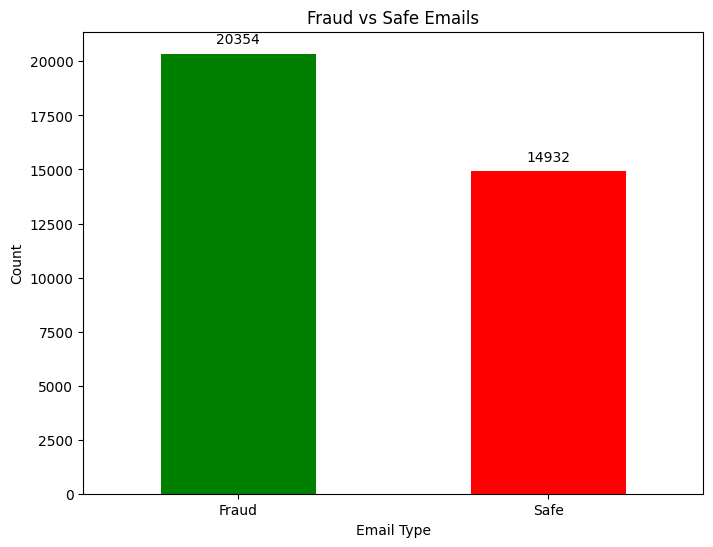

In [16]:
# Count the occurrences of each category in 'is_fraud_email'
fraud_counts = df["is_fraud_email"].value_counts()

# Create a bar plot
plt.figure(figsize=(8, 6))
ax = fraud_counts.plot(kind="bar", color=["green", "red"])

# Adding title and labels
plt.title("Fraud vs Safe Emails")
plt.xlabel("Email Type")
plt.ylabel("Count")

# Add the count values on top of each bar
for p in ax.patches:
    ax.annotate(
        f"{p.get_height()}",
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="center",
        xytext=(0, 10),
        textcoords="offset points",
    )

# Show the plot
plt.xticks(ticks=[0, 1], labels=["Fraud", "Safe"], rotation=0)
plt.show()

## Feature Engineering & Validation

### Subject Length
- A fraud email might have shorter subject length to capture your attention quickly
- Legitimate emails are more likely to be verbose in their subject descriptions

In [17]:
def count_subject_length(text):
    return len(text.split(" "))

In [18]:
df["subject_length"] = df["subject"].apply(count_subject_length)

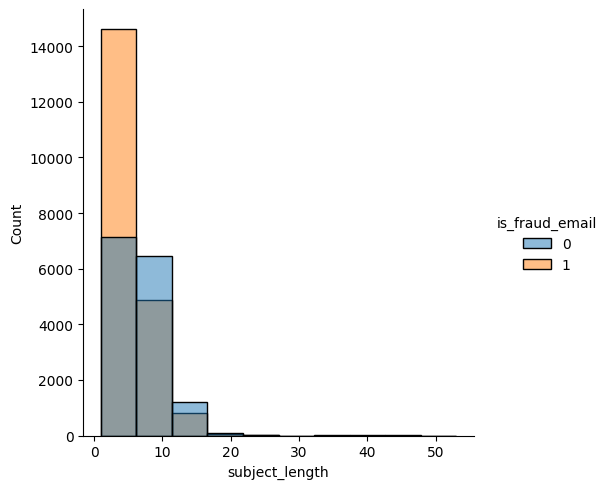

In [19]:
sns.displot(df, x="subject_length", hue="is_fraud_email", kind="hist", bins=10)

In [20]:
avg_subject_length = df.groupby("is_fraud_email")["subject_length"].mean().reset_index()

In [21]:
avg_subject_length

,is_fraud_email,subject_length
0,0,7.090544
1,1,5.482755


<Axes: xlabel='is_fraud_email', ylabel='subject_length'>

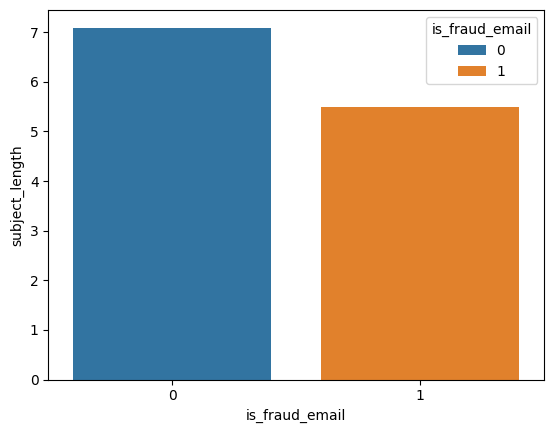

In [22]:
sns.barplot(
    x="is_fraud_email",
    hue="is_fraud_email",
    y="subject_length",
    data=avg_subject_length,
)

### Subject is reply email
- Subjects that are reply email are more likely to be legitimate 
- Phishing emails tend to be new emails

In [23]:
def is_reply_email(text: str):
    return int("Re:" in text)

In [24]:
df["is_reply_email"] = df["subject"].apply(is_reply_email)

<Axes: xlabel='is_reply_email', ylabel='count'>

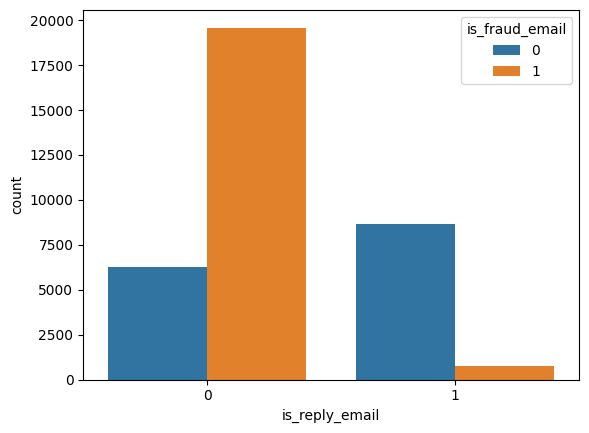

In [25]:
sns.countplot(df, x="is_reply_email", hue="is_fraud_email")

### Subject Sentiment
- A subject that intends to capture your attention might be more positive which is effective in phishing emails
- E.g.
  - a cure to cancer!!! (phishing)
  - new meeting agenda for upcoming feature proposal (legit)

In [26]:
from textblob import TextBlob


def get_subject_sentiment(text):
    return TextBlob(text).sentiment.polarity

In [27]:
df["subject_sentiment"] = df["subject"].apply(get_subject_sentiment)

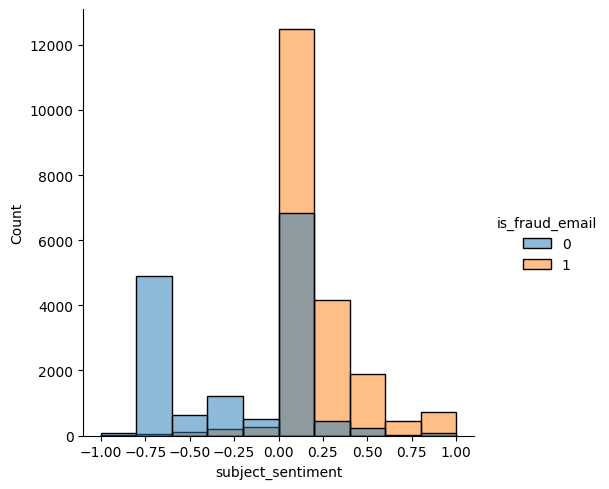

In [28]:
sns.displot(df, x="subject_sentiment", hue="is_fraud_email", kind="hist", bins=10)

In [29]:
df[["subject", "subject_sentiment", "is_fraud_email"]][1000:1005]

,subject,subject_sentiment,is_fraud_email
1000,Thousands of products,0.000,1
1001,Be admired for your true male merits,0.175,1
1002,Prodigious preparation is to your service,0.000,1
1003,Up to 60% Off!,0.000,0
1004,save 90% on watches! visit replica store,0.000,1


### Subject Feature Engineering

A function that handles feature engineering on the subject column and drops the column afterwards

In [30]:
# def feature_engineering_subject(input_df):
#     df = input_df.copy()

#     df["subject_length"] = df["subject"].apply(count_subject_length)
#     df["is_reply_email"] = df["subject"].apply(is_reply_email)
#     df["subject_sentiment"] = df["subject"].apply(get_subject_sentiment)

#     return df

In [31]:
# df = feature_engineering_subject(df)

In [32]:
df.head()

,date,subject,body,is_fraud_email,body_contains_url,sender_name,sender_email,receiver_email,sender_domain,receiver_domain,year,month,day,hour,subject_length,is_reply_email,subject_sentiment
0,2008-08-05 23:31:02+00:00,Never agree to be a loser,"Buck up, your troubles caused by small dimensi...",1,1,Young Esposito,Young@iworld.de,user4@gvc.ceas-challenge.cc,iworld.de,gvc.ceas-challenge.cc,2008,8,5,23,6,0,0.00
1,2008-08-05 23:31:03+00:00,Befriend Jenna Jameson,\nUpgrade your sex and pleasures with these te...,1,1,Mok,ipline's1983@icable.ph,user2.2@gvc.ceas-challenge.cc,icable.ph,gvc.ceas-challenge.cc,2008,8,5,23,3,0,0.00
2,2008-08-06 08:28:00+00:00,CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1,1,Daily Top 10,Karmandeep-opengevl@universalnet.psi.br,user2.9@gvc.ceas-challenge.cc,universalnet.psi.br,gvc.ceas-challenge.cc,2008,8,6,8,4,0,0.25
3,2008-08-05 23:31:20+00:00,Re: svn commit: r619753 - in /spamassassin/tru...,Would anyone object to removing .so from this ...,0,1,Michael Parker,ivqrnai@pobox.com,xrh@spamassassin.apache.org,pobox.com,spamassassin.apache.org,2008,8,5,23,10,1,0.00
4,2008-08-05 23:31:21+00:00,SpecialPricesPharmMoreinfo,\nWelcomeFastShippingCustomerSupport\nhttp://7...,1,1,Gretchen Suggs,externalsep1@loanofficertool.com,user2.2@gvc.ceas-challenge.cc,loanofficertool.com,gvc.ceas-challenge.cc,2008,8,5,23,1,0,0.00


### Time of Email
- Analysing the time in which emails are sent could provide valuable insight about whether they are phishing or not

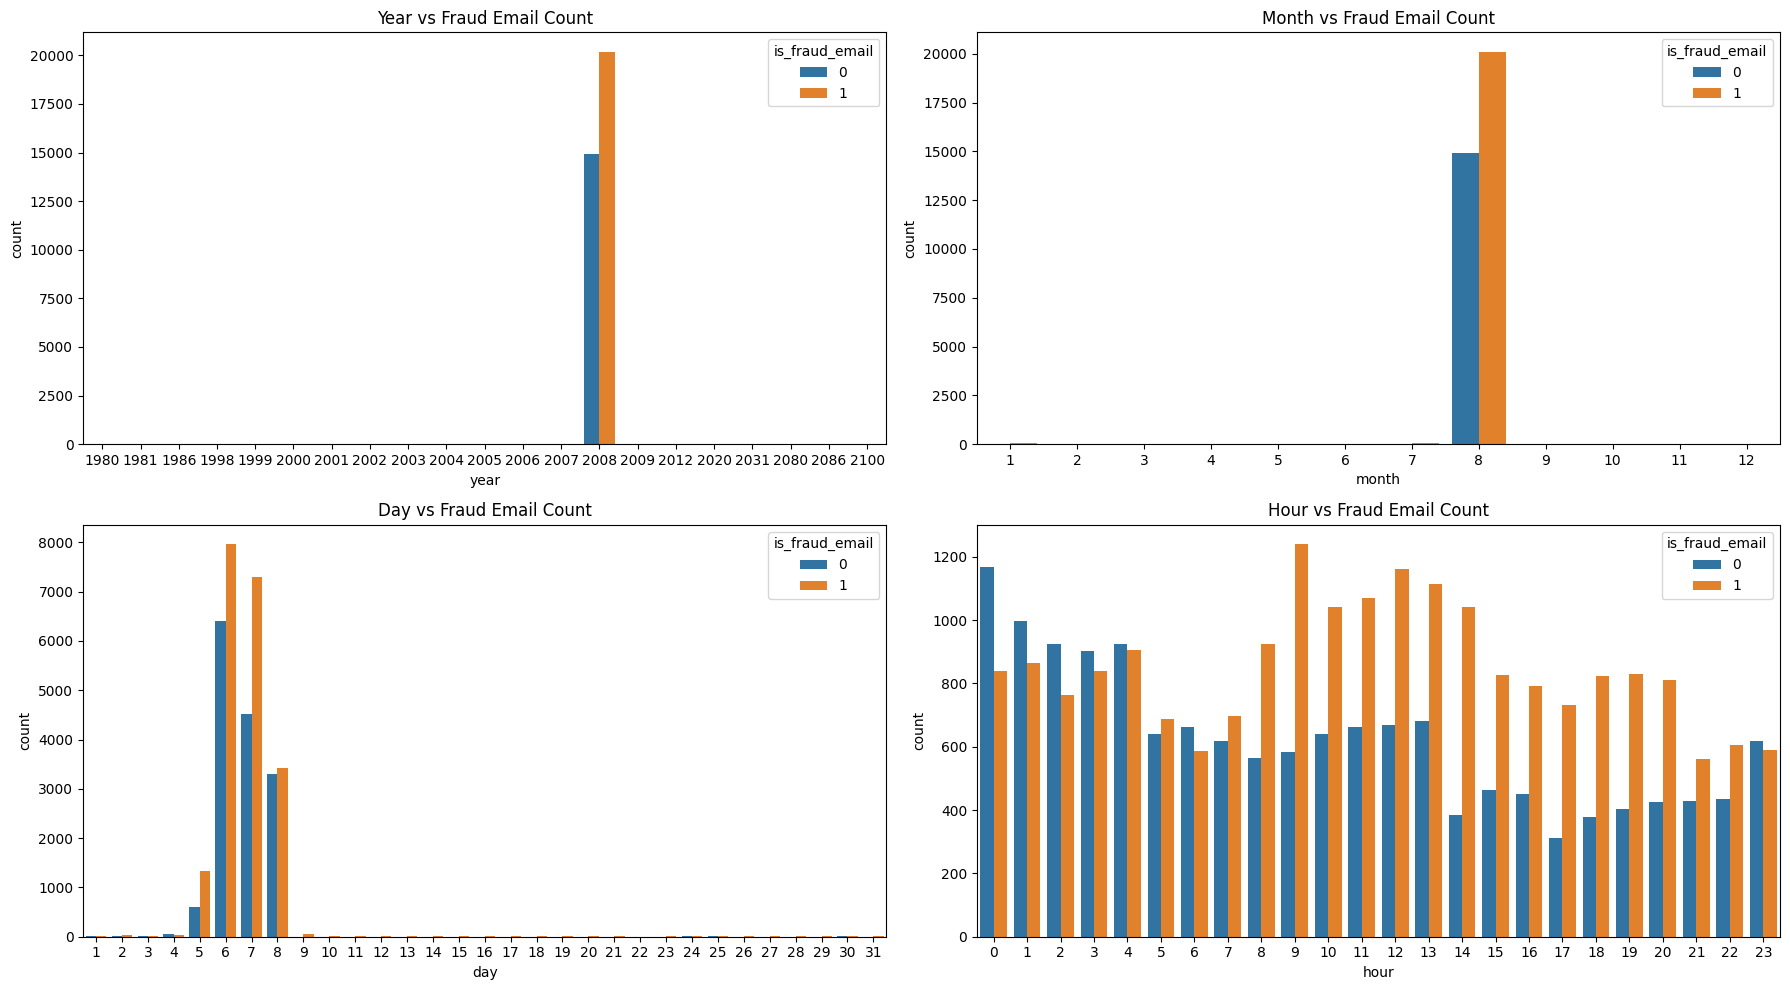

In [33]:
year_fraud_counts = (
    df.groupby(["year", "is_fraud_email"]).size().reset_index(name="count")
)
month_fraud_counts = (
    df.groupby(["month", "is_fraud_email"]).size().reset_index(name="count")
)
day_fraud_counts = (
    df.groupby(["day", "is_fraud_email"]).size().reset_index(name="count")
)
hour_fraud_counts = (
    df.groupby(["hour", "is_fraud_email"]).size().reset_index(name="count")
)

fig, axs = plt.subplots(2, 2, figsize=(18, 10))

sns.barplot(
    x="year", y="count", hue="is_fraud_email", data=year_fraud_counts, ax=axs[0, 0]
)
axs[0, 0].set_title("Year vs Fraud Email Count")

sns.barplot(
    x="month", y="count", hue="is_fraud_email", data=month_fraud_counts, ax=axs[0, 1]
)
axs[0, 1].set_title("Month vs Fraud Email Count")

sns.barplot(
    x="day", y="count", hue="is_fraud_email", data=day_fraud_counts, ax=axs[1, 0]
)
axs[1, 0].set_title("Day vs Fraud Email Count")

sns.barplot(
    x="hour", y="count", hue="is_fraud_email", data=hour_fraud_counts, ax=axs[1, 1]
)
axs[1, 1].set_title("Hour vs Fraud Email Count")

plt.tight_layout()
plt.show()

From the graphs above, we can see that there is a distinct difference in the distribution of `is_fraud_email` for `hour`, whereas the rest does not vary significantly in the distribution. Notably, there is a surge of emails in the year 2008, month of August and across the 5th to 8th of the month. 

We will use `hour` in our analysis

### Body Contains URL
- A phishing email is likely to include urls to tempt people to click on them
- This is a provided feature in the dataset

In [34]:
df.groupby("is_fraud_email")["body_contains_url"].mean().reset_index()

,is_fraud_email,body_contains_url
0,0,0.641508
1,1,0.660607


In [35]:
contingency_table = pd.crosstab(df["is_fraud_email"], df["body_contains_url"])

chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:")
print(expected)

Chi-square statistic: 13.772905497481805
P-value: 0.0002062900133745784
Degrees of freedom: 1
Expected frequencies:
[[ 5188.49549396  9743.50450604]
 [ 7072.50450604 13281.49549396]]


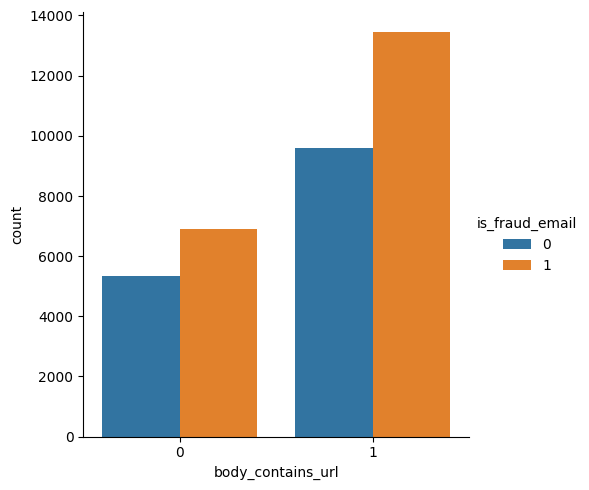

In [36]:
sns.catplot(df, x="body_contains_url", hue="is_fraud_email", kind="count")

### Body Formating
- Phishing emails tend to be formatted poorly compared to legitimate emails
- Legitimate emails may use more new line characters and spaces to format their text better
- We can compute the ratio of these characters to the body text length to determine the number of formatting characters used per character

In [37]:
import string


def count_special_and_formatting_characters(text: str):
    special_characters = set(string.punctuation)

    total_special_characters = sum(1 for char in text if char in special_characters)
    total_newline_characters = text.count("\n")
    total_space_characters = text.count(" ")

    return total_newline_characters + total_space_characters + total_special_characters


def calculate_ratios(text):
    return count_special_and_formatting_characters(text) / (1 + len(text))

In [38]:
df["special_and_formatting_chars_to_body_ratio"] = df["body"].apply(calculate_ratios)

In [39]:
mean_uppercase_count = df.groupby("is_fraud_email")[
    "special_and_formatting_chars_to_body_ratio"
].mean()

print("Mean Ratio:")
print(mean_uppercase_count)

# Perform an independent t-test to compare the means of the two groups
group_0 = df[df["is_fraud_email"] == 0]["special_and_formatting_chars_to_body_ratio"]
group_1 = df[df["is_fraud_email"] == 1]["special_and_formatting_chars_to_body_ratio"]

t_stat, p_value = ttest_ind(group_0, group_1, equal_var=False)

print(t_stat, p_value)

Mean Ratio:
is_fraud_email
0    0.279446
1    0.247494
Name: special_and_formatting_chars_to_body_ratio, dtype: float64
47.35732603682025 0.0


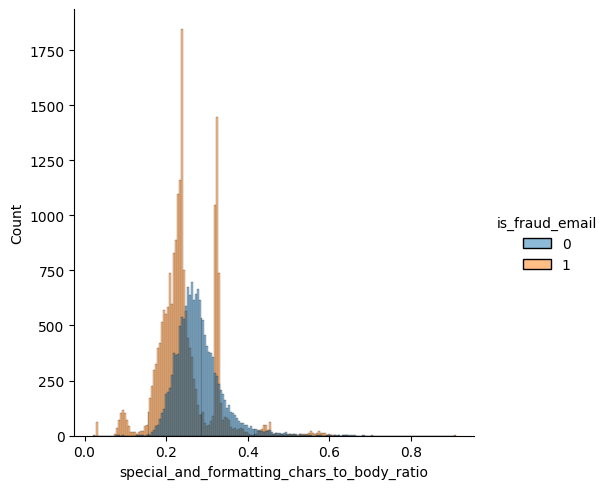

In [40]:
sns.displot(df, x="special_and_formatting_chars_to_body_ratio", hue="is_fraud_email")

### Uppercase Characters in Sender Email

In [41]:
def uppercase_count_in_sender_email(text):
    return sum(1 for char in text if char.isupper())

In [42]:
df["uppercase_count_in_sender_email"] = df["sender_email"].apply(
    uppercase_count_in_sender_email
)

In [43]:
mean_uppercase_count = df.groupby("is_fraud_email")[
    "uppercase_count_in_sender_email"
].mean()

print("Mean Uppercase Count:")
print(mean_uppercase_count)

# Perform an independent t-test to compare the means of the two groups
group_0 = df[df["is_fraud_email"] == 0]["uppercase_count_in_sender_email"]
group_1 = df[df["is_fraud_email"] == 1]["uppercase_count_in_sender_email"]

t_stat, p_value = ttest_ind(group_0, group_1, equal_var=False)

p_value

Mean Uppercase Count:
is_fraud_email
0    0.061278
1    0.648521
Name: uppercase_count_in_sender_email, dtype: float64


0.0

In [44]:
store = df[["sender_email", "uppercase_count_in_sender_email", "is_fraud_email"]]

store[store["uppercase_count_in_sender_email"] > 10].head(5)

,sender_email,uppercase_count_in_sender_email,is_fraud_email
123,Aleksandra-reitodes@AISAN-IND.CO.JP,13,1
425,wray-niitledi@KFSHRC.EDU.SA,11,1
2275,Dobran-nitelopo@FABRIL.COM.BR,12,1
2484,alper-erubelnd@READINGHOSPITAL.ORG,18,1
2954,Derric-maknmabm@LACALHENE.COM,13,1


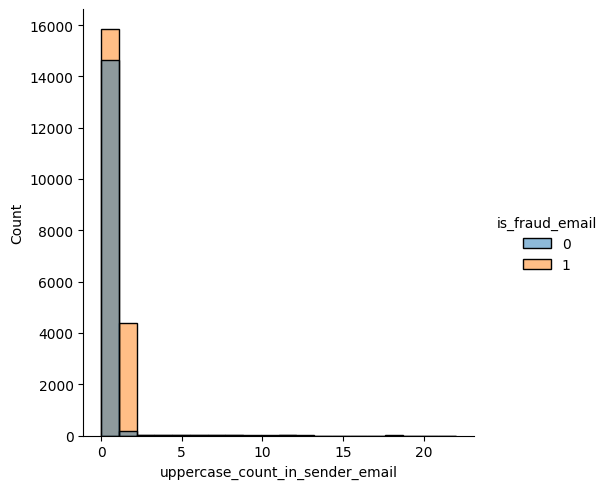

In [45]:
sns.displot(df, x="uppercase_count_in_sender_email", hue="is_fraud_email", bins=20)

### Numbers in Sender Email

In [46]:
def number_count_in_sender_email(text):
    return sum(1 for char in text if char.isdigit())

In [47]:
df["number_count_in_sender_email"] = df["sender_email"].apply(
    number_count_in_sender_email
)

In [48]:
mean_uppercase_count = df.groupby("is_fraud_email")[
    "number_count_in_sender_email"
].mean()

print("Mean Number Count:")
print(mean_uppercase_count)

# Perform an independent t-test to compare the means of the two groups
group_0 = df[df["is_fraud_email"] == 0]["number_count_in_sender_email"]
group_1 = df[df["is_fraud_email"] == 1]["number_count_in_sender_email"]

t_stat, p_value = ttest_ind(group_0, group_1, equal_var=False)

p_value

Mean Number Count:
is_fraud_email
0    0.161398
1    0.835561
Name: number_count_in_sender_email, dtype: float64


0.0

In [49]:
store = df[["sender_email", "number_count_in_sender_email", "is_fraud_email"]]

store[store["number_count_in_sender_email"] > 10].head(5)

,sender_email,number_count_in_sender_email,is_fraud_email
85,ihtnaelc@152.92.149.210.economy.2iij.net,12,1
119,Costantino-sereituo@7.120.138.210.bf.2iij.net,11,1
268,dere-ezidekan@202.21.214.202.ts.2iij.net,12,1
455,98621701966@sla.com,11,1
458,l{m{iv{h_1990@2f022b9a8b9a28309e48e65b932e7af7...,26,1


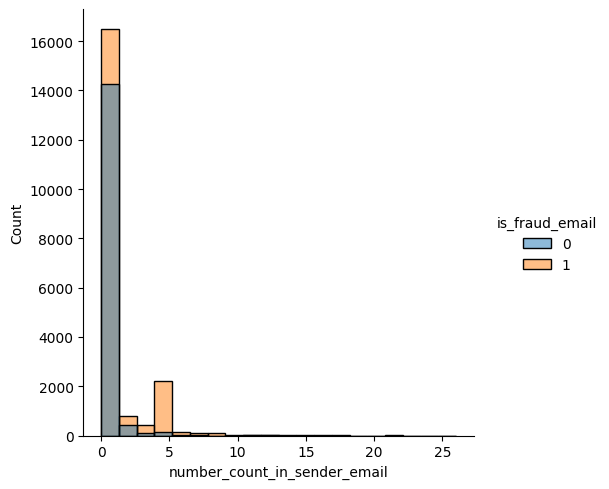

In [50]:
sns.displot(df, x="number_count_in_sender_email", hue="is_fraud_email", bins=20)

### Overview of current columns in dataframe

In [51]:
df.columns

Index(['date', 'subject', 'body', 'is_fraud_email', 'body_contains_url',
       'sender_name', 'sender_email', 'receiver_email', 'sender_domain',
       'receiver_domain', 'year', 'month', 'day', 'hour', 'subject_length',
       'is_reply_email', 'subject_sentiment',
       'special_and_formatting_chars_to_body_ratio',
       'uppercase_count_in_sender_email', 'number_count_in_sender_email'],
      dtype='object')

## Model Training & Evaluation (without sentence embeddings)

- In the first run, we will train machine learning models without the use of sentence embeddings

### Feature Selection

In [52]:
wanted_columns_initial_training = [
    "body_contains_url",
    "hour",
    "subject_length",
    "is_reply_email",
    "subject_sentiment",
    "special_and_formatting_chars_to_body_ratio",
    "uppercase_count_in_sender_email",
    "number_count_in_sender_email",
]

In [53]:
X = df[wanted_columns_initial_training]
y = df["is_fraud_email"]

### Train Test Split

- We will do a 60 / 20 / 20 , train / validation / test split

In [54]:
# Train set and Val + Test set
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=SEED
)

# Split Val + Test set to 50 / 50 splits
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=SEED
)

In [55]:
def train_model(model, X_train, y_train, X_test):
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]

    return y_pred, y_pred_prob


def generate_metrics(y_test, y_pred, y_pred_prob):
    # Confusion Matrix
    # cm = confusion_matrix(y_test, y_pred)
    # print("Confusion Matrix:")
    # print(cm)

    # Classification Report
    cr = classification_report(y_test, y_pred)
    print("Classification Report")
    print(cr)

    # AUC Score
    auc_score = roc_auc_score(y_test, y_pred_prob)
    print(f"AUC Score: {auc_score:.4f}")

    # Optional: Plotting the ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    plt.figure()
    plt.plot(fpr, tpr, color="blue", label="ROC curve (area = %0.2f)" % auc_score)
    plt.plot([0, 1], [0, 1], color="red", linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic")
    plt.legend(loc="lower right")
    plt.show()

### SVM

Classification Report
              precision    recall  f1-score   support

           0       0.94      0.76      0.84      3043
           1       0.84      0.96      0.90      4014

    accuracy                           0.87      7057
   macro avg       0.89      0.86      0.87      7057
weighted avg       0.88      0.87      0.87      7057

AUC Score: 0.9372


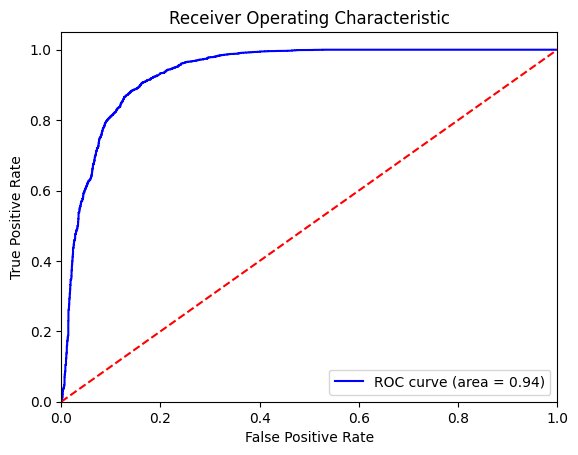

In [56]:
svm_classifier = SVC(kernel="rbf", probability=True)

y_val_pred, y_val_pred_prob = train_model(svm_classifier, X_train, y_train, X_val)

generate_metrics(y_val, y_val_pred, y_val_pred_prob)

### Random Forest 

Classification Report
              precision    recall  f1-score   support

           0       0.92      0.91      0.92      3043
           1       0.93      0.94      0.94      4014

    accuracy                           0.93      7057
   macro avg       0.93      0.93      0.93      7057
weighted avg       0.93      0.93      0.93      7057

AUC Score: 0.9815


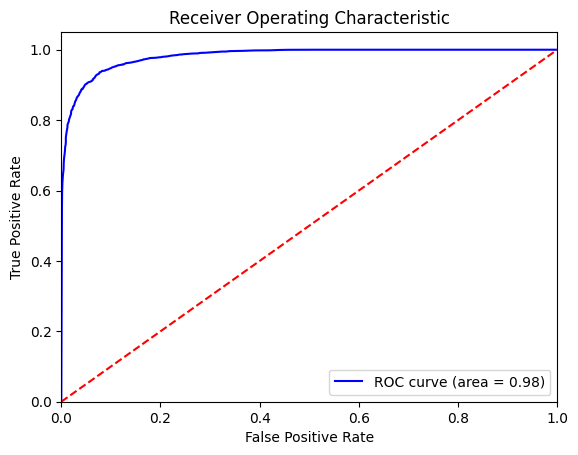

In [57]:
rf_classifier = RandomForestClassifier(n_estimators=200)

y_val_pred, y_val_pred_prob = train_model(rf_classifier, X_train, y_train, X_val)

generate_metrics(y_val, y_val_pred, y_val_pred_prob)

### Neural Network

Classification Report
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      3043
           1       0.91      0.93      0.92      4014

    accuracy                           0.91      7057
   macro avg       0.91      0.91      0.91      7057
weighted avg       0.91      0.91      0.91      7057

AUC Score: 0.9716


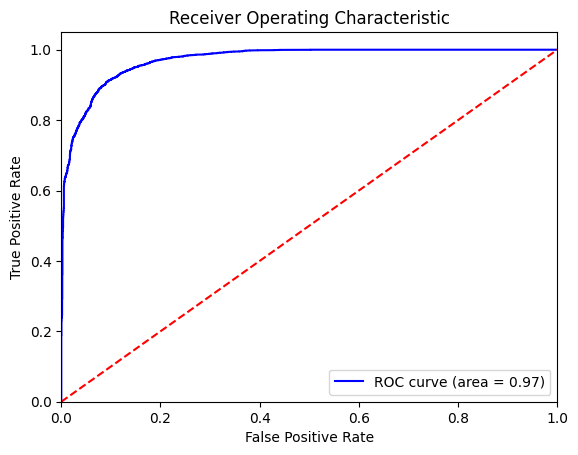

In [58]:
nn_model = MLPClassifier(hidden_layer_sizes=(200,), max_iter=5000)

y_val_pred, y_val_pred_prob = train_model(nn_model, X_train, y_train, X_val)

generate_metrics(y_val, y_val_pred, y_val_pred_prob)

### Evaluating on Test Set
- Random Forest Classifier appears to perform the best with the highest ROC
- We will now evaluate it on the test set

Classification Report
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      2890
           1       0.94      0.93      0.94      4168

    accuracy                           0.92      7058
   macro avg       0.92      0.92      0.92      7058
weighted avg       0.92      0.92      0.92      7058

AUC Score: 0.9817


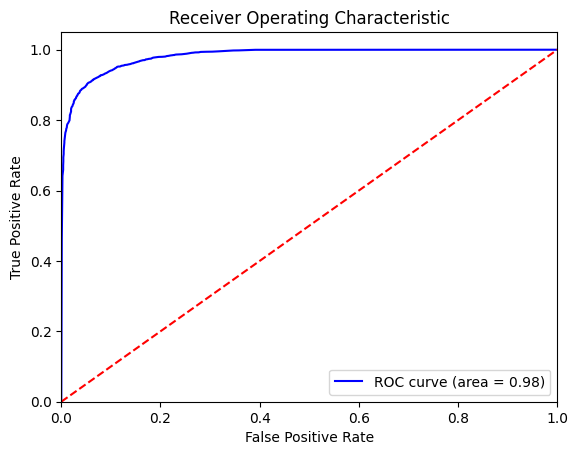

In [59]:
y_test_pred = rf_classifier.predict(X_test)
y_test_pred_prob = rf_classifier.predict_proba(X_test)[:, 1]

generate_metrics(y_test, y_test_pred, y_test_pred_prob)

## Vectorizing Texts
- Our 3 models have performed well without the use of text vectorization
- We will now incorporate vector embeddings of the body of the email into the training data to see if any improvements could be made
- We will use `TF-IDF` on lemmatized text and `Sentence Transformers (mpnet)` on un-lemmatized text, creating 2 different datasets
- As the feature space is large on `TF-IDF`, we will limit to the top 5000 features to ensure that the row-space is still larger than the column space

In [60]:
df.head()

,date,subject,body,is_fraud_email,body_contains_url,sender_name,sender_email,receiver_email,sender_domain,receiver_domain,year,month,day,hour,subject_length,is_reply_email,subject_sentiment,special_and_formatting_chars_to_body_ratio,uppercase_count_in_sender_email,number_count_in_sender_email
0,2008-08-05 23:31:02+00:00,Never agree to be a loser,"Buck up, your troubles caused by small dimensi...",1,1,Young Esposito,Young@iworld.de,user4@gvc.ceas-challenge.cc,iworld.de,gvc.ceas-challenge.cc,2008,8,5,23,6,0,0.00,0.218978,1,0
1,2008-08-05 23:31:03+00:00,Befriend Jenna Jameson,\nUpgrade your sex and pleasures with these te...,1,1,Mok,ipline's1983@icable.ph,user2.2@gvc.ceas-challenge.cc,icable.ph,gvc.ceas-challenge.cc,2008,8,5,23,3,0,0.00,0.204819,0,4
2,2008-08-06 08:28:00+00:00,CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1,1,Daily Top 10,Karmandeep-opengevl@universalnet.psi.br,user2.9@gvc.ceas-challenge.cc,universalnet.psi.br,gvc.ceas-challenge.cc,2008,8,6,8,4,0,0.25,0.324062,1,0
3,2008-08-05 23:31:20+00:00,Re: svn commit: r619753 - in /spamassassin/tru...,Would anyone object to removing .so from this ...,0,1,Michael Parker,ivqrnai@pobox.com,xrh@spamassassin.apache.org,pobox.com,spamassassin.apache.org,2008,8,5,23,10,1,0.00,0.335558,0,0
4,2008-08-05 23:31:21+00:00,SpecialPricesPharmMoreinfo,\nWelcomeFastShippingCustomerSupport\nhttp://7...,1,1,Gretchen Suggs,externalsep1@loanofficertool.com,user2.2@gvc.ceas-challenge.cc,loanofficertool.com,gvc.ceas-challenge.cc,2008,8,5,23,1,0,0.00,0.102273,0,1


### Text Preprocessing

In [61]:
# Download nltk datasets

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package punkt to /Users/geraldho/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/geraldho/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/geraldho/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/geraldho/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

#### Preprocess without lemmatization
Maintains contextual semantics and meaning

In [62]:
def preprocess_text(text: str) -> str:
    # Lowercase the text
    text = str(text).lower()

    # Remove punctuation, numbers, and special characters
    text = re.sub(r"[^a-z\s]", "", text)

    # Tokenize the text
    words = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words("english"))
    words = [word for word in words if word not in stop_words]

    # Join the words back into a single string
    return " ".join(words)


df["processed_text"] = df["body"].apply(preprocess_text)
df["processed_text"]

0        buck troubles caused small dimension soon beco...
1        upgrade sex pleasures techniques httpwwwbright...
2        daily top cnncom top videos stories aug pm edt...
3        would anyone object removing list tld basicall...
4        welcomefastshippingcustomersupport httpiwfnabl...
                               ...                        
35281    cnn alerts custom alert alert name custom aler...
35282    cnn alerts custom alert alert name custom aler...
35283    hello great work slide show viewer application...
35284    mail sender coming intuitcom servers subject t...
35285    dear fellow pythonistas guido accepted user si...
Name: processed_text, Length: 35286, dtype: object

#### Preprocessing with lemmatization 

Raw words

In [63]:
def apply_lemmatization(text: str) -> str:
    words = text.split()

    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]

    # Join the words back into a single string
    return " ".join(words)


df["processed_lemmatized_text"] = df["processed_text"].apply(apply_lemmatization)
df["processed_lemmatized_text"]

0        buck trouble caused small dimension soon becom...
1        upgrade sex pleasure technique httpwwwbrightma...
2        daily top cnncom top video story aug pm edt to...
3        would anyone object removing list tld basicall...
4        welcomefastshippingcustomersupport httpiwfnabl...
                               ...                        
35281    cnn alert custom alert alert name custom alert...
35282    cnn alert custom alert alert name custom alert...
35283    hello great work slide show viewer application...
35284    mail sender coming intuitcom server subject tu...
35285    dear fellow pythonistas guido accepted user si...
Name: processed_lemmatized_text, Length: 35286, dtype: object

In [64]:
df.head()

,date,subject,body,is_fraud_email,body_contains_url,sender_name,sender_email,receiver_email,sender_domain,receiver_domain,...,day,hour,subject_length,is_reply_email,subject_sentiment,special_and_formatting_chars_to_body_ratio,uppercase_count_in_sender_email,number_count_in_sender_email,processed_text,processed_lemmatized_text
0,2008-08-05 23:31:02+00:00,Never agree to be a loser,"Buck up, your troubles caused by small dimensi...",1,1,Young Esposito,Young@iworld.de,user4@gvc.ceas-challenge.cc,iworld.de,gvc.ceas-challenge.cc,...,5,23,6,0,0.00,0.218978,1,0,buck troubles caused small dimension soon beco...,buck trouble caused small dimension soon becom...
1,2008-08-05 23:31:03+00:00,Befriend Jenna Jameson,\nUpgrade your sex and pleasures with these te...,1,1,Mok,ipline's1983@icable.ph,user2.2@gvc.ceas-challenge.cc,icable.ph,gvc.ceas-challenge.cc,...,5,23,3,0,0.00,0.204819,0,4,upgrade sex pleasures techniques httpwwwbright...,upgrade sex pleasure technique httpwwwbrightma...
2,2008-08-06 08:28:00+00:00,CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1,1,Daily Top 10,Karmandeep-opengevl@universalnet.psi.br,user2.9@gvc.ceas-challenge.cc,universalnet.psi.br,gvc.ceas-challenge.cc,...,6,8,4,0,0.25,0.324062,1,0,daily top cnncom top videos stories aug pm edt...,daily top cnncom top video story aug pm edt to...
3,2008-08-05 23:31:20+00:00,Re: svn commit: r619753 - in /spamassassin/tru...,Would anyone object to removing .so from this ...,0,1,Michael Parker,ivqrnai@pobox.com,xrh@spamassassin.apache.org,pobox.com,spamassassin.apache.org,...,5,23,10,1,0.00,0.335558,0,0,would anyone object removing list tld basicall...,would anyone object removing list tld basicall...
4,2008-08-05 23:31:21+00:00,SpecialPricesPharmMoreinfo,\nWelcomeFastShippingCustomerSupport\nhttp://7...,1,1,Gretchen Suggs,externalsep1@loanofficertool.com,user2.2@gvc.ceas-challenge.cc,loanofficertool.com,gvc.ceas-challenge.cc,...,5,23,1,0,0.00,0.102273,0,1,welcomefastshippingcustomersupport httpiwfnabl...,welcomefastshippingcustomersupport httpiwfnabl...


## TF-IDF 

### Creating the Desired Dataset

In [65]:
wanted_columns_tfidf = [
    "body_contains_url",
    "hour",
    "subject_length",
    "is_reply_email",
    "subject_sentiment",
    "special_and_formatting_chars_to_body_ratio",
    "uppercase_count_in_sender_email",
    "number_count_in_sender_email",
    "processed_lemmatized_text",
]

In [66]:
X_tfidf = df[wanted_columns_tfidf]
y_tfidf = df["is_fraud_email"]

# Train set and Val + Test set
X_train_tfidf, X_temp_tfidf, y_train_tfidf, y_temp_tfidf = train_test_split(
    X_tfidf, y_tfidf, test_size=0.4, random_state=SEED
)

# Split Val + Test set to 50 / 50 splits
X_val_tfidf, X_test_tfidf, y_val_tfidf, y_test_tfidf = train_test_split(
    X_temp_tfidf, y_temp_tfidf, test_size=0.5, random_state=SEED
)

X_train_tfidf.reset_index(inplace=True)
X_val_tfidf.reset_index(inplace=True)
X_test_tfidf.reset_index(inplace=True)

In [67]:
tfidf_vectorizer = TfidfVectorizer()

X_train_tfidf_matrix = tfidf_vectorizer.fit_transform(
    X_train_tfidf["processed_lemmatized_text"]
)
X_val_tfidf_matrix = tfidf_vectorizer.transform(
    X_val_tfidf["processed_lemmatized_text"]
)
X_test_tfidf_matrix = tfidf_vectorizer.transform(
    X_test_tfidf["processed_lemmatized_text"]
)

X_train_tfidf_matrix

<21171x110046 sparse matrix of type '<class 'numpy.float64'>'
	with 1563254 stored elements in Compressed Sparse Row format>

The value 110046 illustrates the number of dimensions the bag of words contain. As the number if rather large, we will be reducing the number of features by removing low-variance features (i.e., words that hardly appear). 

In [68]:
threshold = 0.0005

selector = VarianceThreshold(threshold)

X_train_tfidf_matrix_selected = selector.fit_transform(X_train_tfidf_matrix)
X_val_tfidf_matrix_selected = selector.transform(X_val_tfidf_matrix)
X_test_tfidf_matrix_selected = selector.transform(X_test_tfidf_matrix)

feature_mask = selector.get_support()
feature_names = tfidf_vectorizer.get_feature_names_out()

reduced_feature_names = feature_names[feature_mask]

X_train_tfidf_df = pd.DataFrame(
    X_train_tfidf_matrix_selected.toarray(), columns=reduced_feature_names
)
X_val_tfidf_df = pd.DataFrame(
    X_val_tfidf_matrix_selected.toarray(), columns=reduced_feature_names
)
X_test_tfidf_df = pd.DataFrame(
    X_test_tfidf_matrix_selected.toarray(), columns=reduced_feature_names
)

In [69]:
# combine the datasets
X_train_tfidf = pd.concat([X_train_tfidf, X_train_tfidf_df], axis=1)
X_val_tfidf = pd.concat([X_val_tfidf, X_val_tfidf_df], axis=1)
X_test_tfidf = pd.concat([X_test_tfidf, X_test_tfidf_df], axis=1)

In [70]:
X_train_tfidf.head(3)

,index,body_contains_url,hour,subject_length,is_reply_email,subject_sentiment,special_and_formatting_chars_to_body_ratio,uppercase_count_in_sender_email,number_count_in_sender_email,processed_lemmatized_text,...,watch,week,weight,within,woman,work,workshop,world,would,wrote
0,20072,1,9,4,0,0.25,0.327184,1,0,daily top cnncom top video story aug pm edt to...,...,0.0,0.0,0.0,0.0,0.057594,0.00000,0.0,0.000000,0.0,0.000000
1,23708,1,6,5,0,0.00,0.212121,2,0,get free bottle today change life wait thanks ...,...,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.000000,0.0,0.000000
2,29859,0,3,8,1,0.00,0.289067,0,0,ill give shot thanks matt kettler wrote mike f...,...,0.0,0.0,0.0,0.0,0.000000,0.07332,0.0,0.050703,0.0,0.066239


In [71]:
X_train_tfidf.drop("processed_lemmatized_text", axis=1, inplace=True)
X_val_tfidf.drop("processed_lemmatized_text", axis=1, inplace=True)
X_test_tfidf.drop("processed_lemmatized_text", axis=1, inplace=True)

## Model Training & Evaluation (TF-IDF)

### SVM

In [72]:
# svm_classifier_tfidf = SVC(kernel="rbf", probability=True)

# y_val_pred_tfidf, y_val_pred_prob_tfidf = train_model(svm_classifier_tfidf, X_train_tfidf, y_train_tfidf, X_val_tfidf)

# generate_metrics(y_val_tfidf, y_val_pred_tfidf, y_val_pred_prob_tfidf)

### Random Forest

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3043
           1       0.99      1.00      0.99      4014

    accuracy                           0.99      7057
   macro avg       0.99      0.99      0.99      7057
weighted avg       0.99      0.99      0.99      7057

AUC Score: 0.9990


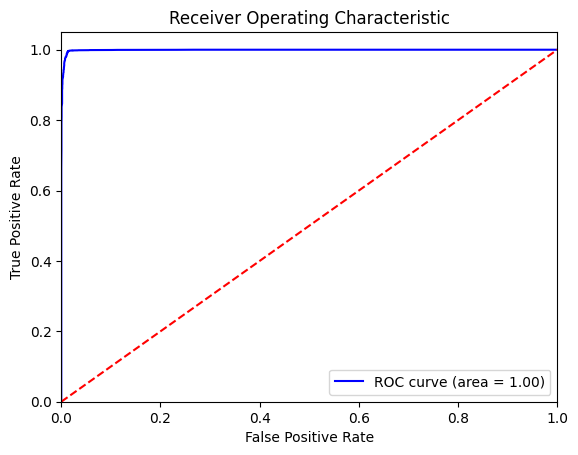

In [73]:
rf_classifier_tfidf = RandomForestClassifier(n_estimators=200)

y_val_pred_tfidf, y_val_pred_prob_tfidf = train_model(
    rf_classifier_tfidf, X_train_tfidf, y_train_tfidf, X_val_tfidf
)

generate_metrics(y_val_tfidf, y_val_pred_tfidf, y_val_pred_prob_tfidf)

### Neural Network

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.40      0.57      3043
           1       0.69      0.99      0.81      4014

    accuracy                           0.74      7057
   macro avg       0.83      0.70      0.69      7057
weighted avg       0.81      0.74      0.71      7057

AUC Score: 0.9003


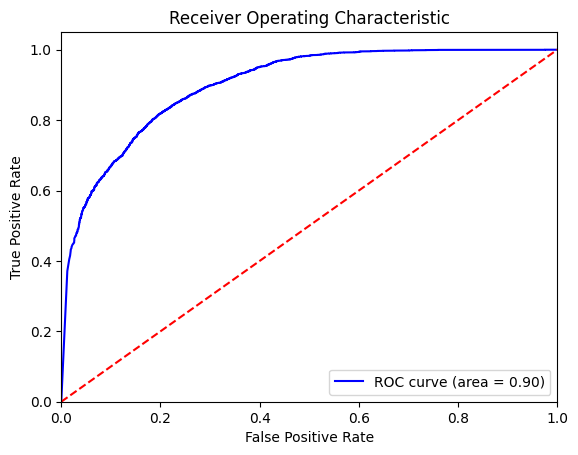

In [74]:
nn_model_tfidf = MLPClassifier(hidden_layer_sizes=(200,), max_iter=5000)

y_val_pred_tfidf, y_val_pred_prob_tfidf = train_model(
    nn_model_tfidf, X_train_tfidf, y_train_tfidf, X_val_tfidf
)

generate_metrics(y_val_tfidf, y_val_pred_tfidf, y_val_pred_prob_tfidf)

### Evaluating on Test Set (TF-IDF)
- Random Forest Classifier appears to perform the best with the highest ROC (almost 1)
- We will now evaluate it on the test set

Classification Report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2890
           1       0.99      0.99      0.99      4168

    accuracy                           0.99      7058
   macro avg       0.99      0.99      0.99      7058
weighted avg       0.99      0.99      0.99      7058

AUC Score: 0.9991


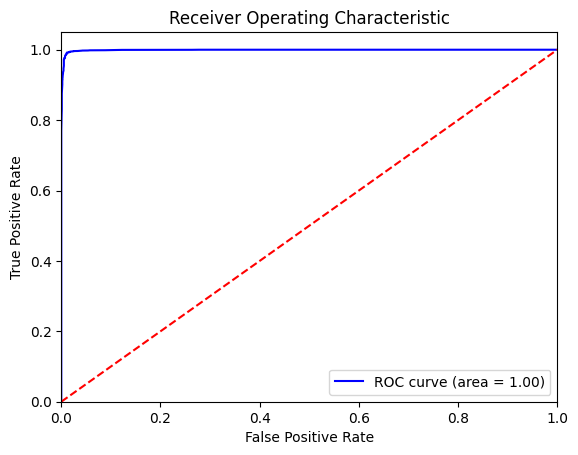

In [75]:
y_test_pred_tfidf = rf_classifier_tfidf.predict(X_test_tfidf)
y_test_pred_prob_tfidf = rf_classifier_tfidf.predict_proba(X_test_tfidf)[:, 1]

generate_metrics(y_test_tfidf, y_test_pred_tfidf, y_test_pred_prob_tfidf)

### Sentence Transformers - MPNet

In [76]:
wanted_columns_st = [
    "body_contains_url",
    "hour",
    "subject_length",
    "is_reply_email",
    "subject_sentiment",
    "special_and_formatting_chars_to_body_ratio",
    "uppercase_count_in_sender_email",
    "number_count_in_sender_email",
    "processed_text",
]

In [77]:
X_st = df[wanted_columns_st]
y_st = df["is_fraud_email"]

# Train set and Val + Test set
X_train_st, X_temp_st, y_train_st, y_temp_st = train_test_split(
    X_st, y_st, test_size=0.4, random_state=SEED
)

# Split Val + Test set to 50 / 50 splits
X_val_st, X_test_st, y_val_st, y_test_st = train_test_split(
    X_temp_st, y_temp_st, test_size=0.5, random_state=SEED
)

X_train_st.reset_index(inplace=True)
X_val_st.reset_index(inplace=True)
X_test_st.reset_index(inplace=True)

In [78]:
file_path_train = "./models/sentence_transformer/train_embeddings.npy"
file_path_val = "./models/sentence_transformer/val_embeddings.npy"
file_path_test = "./models/sentence_transformer/test_embeddings.npy"

# Check if the file exists
if (
    os.path.exists(file_path_train)
    and os.path.exists(file_path_test)
    and os.path.exists(file_path_val)
):
    train_embeddings = np.load(file_path_train)
    val_embeddings = np.load(file_path_val)
    test_embeddings = np.load(file_path_test)
else:
    # Load the MPNet model
    sentence_transformer_model = SentenceTransformer("all-mpnet-base-v2")

    # Encode the texts
    train_embeddings = sentence_transformer_model.encode(
        X_train_st["processed_text"].tolist()
    )
    val_embeddings = sentence_transformer_model.encode(
        X_val_st["processed_text"].tolist()
    )
    test_embeddings = sentence_transformer_model.encode(
        X_test_st["processed_text"].tolist()
    )

    np.save(file_path_train, train_embeddings)
    np.save(file_path_val, val_embeddings)
    np.save(file_path_test, test_embeddings)

X_train_st_df = pd.DataFrame(train_embeddings)
X_val_st_df = pd.DataFrame(val_embeddings)
X_test_st_df = pd.DataFrame(test_embeddings)

In [79]:
X_train_st.drop("processed_text", axis=1, inplace=True)
X_val_st.drop("processed_text", axis=1, inplace=True)
X_test_st.drop("processed_text", axis=1, inplace=True)

In [80]:
X_train_st_df.columns = X_train_st_df.columns.astype(str)
X_val_st_df.columns = X_val_st_df.columns.astype(str)
X_test_st_df.columns = X_test_st_df.columns.astype(str)

In [81]:
# combine the datasets
X_train_st = pd.concat([X_train_st, X_train_st_df], axis=1)
X_val_st = pd.concat([X_val_st, X_val_st_df], axis=1)
X_test_st = pd.concat([X_test_st, X_test_st_df], axis=1)

In [82]:
X_train_st.head(3)

,index,body_contains_url,hour,subject_length,is_reply_email,subject_sentiment,special_and_formatting_chars_to_body_ratio,uppercase_count_in_sender_email,number_count_in_sender_email,0,...,758,759,760,761,762,763,764,765,766,767
0,20072,1,9,4,0,0.25,0.327184,1,0,0.030689,...,-0.022919,0.033274,-0.032379,-0.003100,0.005012,0.034340,-0.031739,-0.019658,-0.039011,-0.007887
1,23708,1,6,5,0,0.00,0.212121,2,0,0.046284,...,0.036121,0.014700,-0.004190,0.019229,-0.009407,0.044365,-0.025799,-0.003976,-0.003489,-0.077026
2,29859,0,3,8,1,0.00,0.289067,0,0,0.021217,...,-0.015435,-0.045610,0.006561,0.046616,-0.014869,0.019166,0.033631,-0.014721,-0.004310,-0.018653


## Model Training & Evaluation (Sentence Transformer)

### SVM

In [83]:
# svm_classifier_st = SVC(kernel="linear", probability=True)

# y_val_pred_st, y_val_pred_prob_st = train_model(svm_classifier_st, X_train_st, y_train_st, X_val_st)

# generate_metrics(y_val_st, y_val_pred_st, y_val_pred_prob_st)

### Random Forest

Classification Report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3043
           1       0.99      0.99      0.99      4014

    accuracy                           0.99      7057
   macro avg       0.99      0.99      0.99      7057
weighted avg       0.99      0.99      0.99      7057

AUC Score: 0.9992


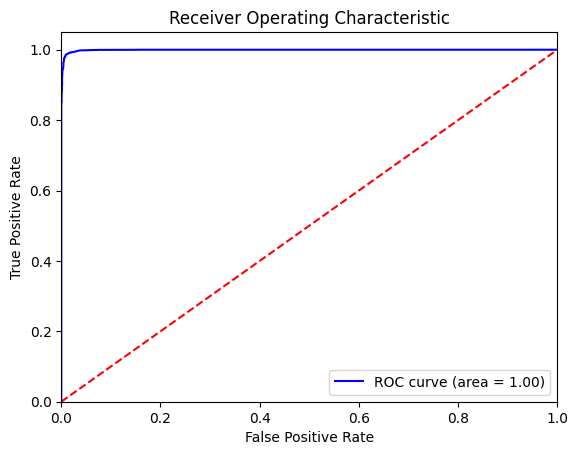

In [84]:
rf_classifier_st = RandomForestClassifier(n_estimators=200)

y_val_pred_st, y_val_pred_prob_st = train_model(
    rf_classifier_st, X_train_st, y_train_st, X_val_st
)

generate_metrics(y_val_st, y_val_pred_st, y_val_pred_prob_st)

### Neural Network

Classification Report
              precision    recall  f1-score   support

           0       0.99      0.84      0.91      3043
           1       0.89      1.00      0.94      4014

    accuracy                           0.93      7057
   macro avg       0.94      0.92      0.92      7057
weighted avg       0.93      0.93      0.93      7057

AUC Score: 0.9913


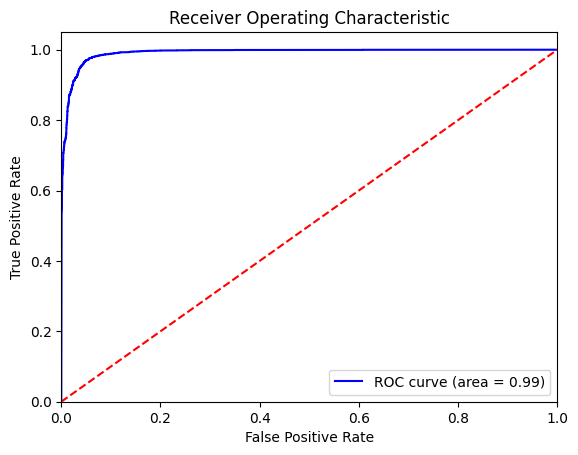

In [85]:
nn_model_st = MLPClassifier(hidden_layer_sizes=(200,), max_iter=5000)

y_val_pred_st, y_val_pred_prob_st = train_model(
    nn_model_st, X_train_st, y_train_st, X_val_st
)

generate_metrics(y_val_st, y_val_pred_st, y_val_pred_prob_st)

### Evaluating on Test Set (Sentence Transformer)
- Random Forest Classifier appears to perform the best with the highest ROC (almost 1)
- We will now evaluate it on the test set

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      2890
           1       0.99      0.99      0.99      4168

    accuracy                           0.99      7058
   macro avg       0.99      0.99      0.99      7058
weighted avg       0.99      0.99      0.99      7058

AUC Score: 0.9993


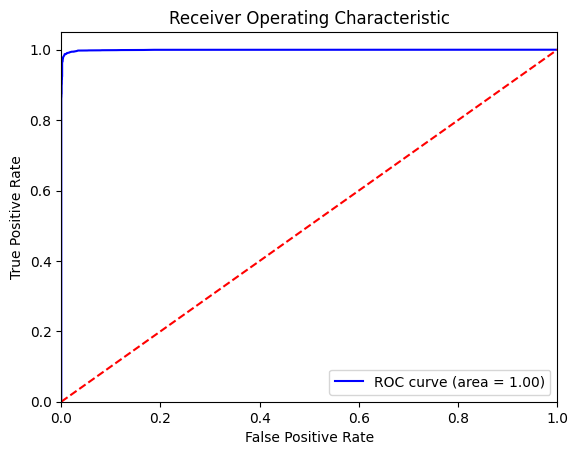

In [86]:
y_test_pred_st = rf_classifier_st.predict(X_test_st)
y_test_pred_prob_st = rf_classifier_st.predict_proba(X_test_st)[:, 1]

generate_metrics(y_test_st, y_test_pred_st, y_test_pred_prob_st)

# ARCHIVED PORTIONS

### Categorical Features

In [87]:
# contingency_table = pd.crosstab(df["sender_domain"], y_train["is_fraud_email"])
# chi2, p, dof, expected = chi2_contingency(contingency_table)

# print(f"Chi-Square Statistic: {chi2}")
# print(f"P-value: {p}")

As p-value < 0.05, there is sufficient evidence to reject the null hypothesis and conclude that there is a statistically significant association between `sender_domain` and `is_fraud_email`. We will perform one-hot encoding for this variable so as to include it in subsequent analysis. 

In [88]:
# encoder = OneHotEncoder(handle_unknown="ignore")

# X_train_encoded = encoder.fit_transform(X_train[["sender_domain"]])
# X_test_encoded = encoder.transform(X_test[["sender_domain"]])

# # Convert the encoded arrays back to DataFrames for better readability (optional)
# X_train_sender_domain_df = pd.DataFrame(
#     X_train_encoded.toarray(), columns=encoder.get_feature_names_out()
# )
# X_test_sender_domain_df = pd.DataFrame(
#     X_test_encoded.toarray(), columns=encoder.get_feature_names_out(["sender_domain"])
# )

### Pre-Processing Email Text

##### Bag of Words

In [89]:
# count_vectorizer = CountVectorizer()

# X_train_bow = count_vectorizer.fit_transform(X_train["processed_lemmatized_text"])
# X_test_bow = count_vectorizer.transform(X_test["processed_lemmatized_text"])

# X_train_bow

The value 128273 illustrates the number of dimensions the bag of words contain. As the number if rather large, we will be reducing the number of features by removing low-variance features (i.e., words that hardly appear). 

In [90]:
# selector = VarianceThreshold(threshold=0.05)

# X_train_bow = selector.fit_transform(X_train_bow)
# X_test_bow = selector.transform(X_test_bow)
# feature_mask = selector.get_support()
# feature_names = count_vectorizer.get_feature_names_out()
# reduced_feature_names = feature_names[feature_mask]

# X_train_bow_df = pd.DataFrame(X_train_bow.toarray(), columns=reduced_feature_names)
# X_test_bow_df = pd.DataFrame(X_test_bow.toarray(), columns=reduced_feature_names)

# X_train_bow_df.shape[1]

##### Word2Vec

In [91]:
# def get_average_vector(words, model):
#     word_vectors = [model.wv[word] for word in words if word in model.wv]
#     if not word_vectors:  # If no words are in the model's vocabulary
#         return np.zeros(model.vector_size)
#     return np.mean(word_vectors, axis=0)

In [92]:
# # ## Post Processing Data Visualisation
# From the graphs above, we can see that there is a distinct difference in the distribution of `is_fraud_email` for `hour`, whereas the rest does not vary significantly in the distribution. Notably, there is a surge of emails in the year 2008, month of August and across the 5th to 8th of the month.
# ## Feature Selection
# X_train.info()
# # following our analysis, we will be keeping:
# #   body_contains_url, sender_domain (one-hot encoded), hour, body (the embedded text)
# # dropped receiver_domain as anyone could receive fraudulent emails?
# # TODO: Decide on what to do about subject
# X_train = X_train[["body_contains_url", "hour"]]
# X_test = X_test[["body_contains_url", "hour"]]

# X_train = X_train.reset_index(drop=True)
# X_train_sender_domain_df = X_train_sender_domain_df.reset_index(drop=True)
# X_test = X_test.reset_index(drop=True)
# X_test_sender_domain_df = X_test_sender_domain_df.reset_index(drop=True)

# # concatenate one-hot encoded sender_domain
# X_train = pd.concat([X_train, X_train_sender_domain_df], axis=1)
# X_test = pd.concat([X_test, X_test_sender_domain_df], axis=1)
# # concatenate body: bag of words
# X_train_bow_df = X_train_bow_df.reset_index(drop=True)
# X_test_bow_df = X_test_bow_df.reset_index(drop=True)

# X_train_body_bow = pd.concat([X_train, X_train_bow_df], axis=1)
# X_test_body_bow = pd.concat([X_test, X_test_bow_df], axis=1)
# # concatenate body: tfidf
# X_train_tfidf_df = X_train_tfidf_df.reset_index(drop=True)
# X_test_tfidf_df = X_test_tfidf_df.reset_index(drop=True)

# X_train_body_tfidf = pd.concat([X_train, X_train_tfidf_df], axis=1)
# X_test_body_tfidf = pd.concat([X_test, X_test_tfidf_df], axis=1)
# # concatenate body: word2vec
# X_train_word2vec_df = X_train_word2vec_df.reset_index(drop=True)
# X_test_word2vec_df = X_test_word2vec_df.reset_index(drop=True)

# X_train_body_word2vec = pd.concat([X_train, X_train_word2vec_df], axis=1)
# X_test_body_word2vec = pd.concat([X_test, X_test_word2vec_df], axis=1)
# # concatenate body: sentence transformers
# X_train_st_df = X_train_st_df.reset_index(drop=True)
# X_test_st_df = X_test_st_df.reset_index(drop=True)

# X_train_body_st = pd.concat([X_train, X_train_st_df], axis=1)
# X_test_body_st = pd.concat([X_test, X_test_st_df], axis=1)

## Modelling

In [93]:
# def run_set(model_class, params=None):
#     def run_model(X_train, X_test):
#         model_params = params if params is not None else {}
#         model = model_class(**model_params)  # Pass any necessary parameters here
#         model.fit(X_train, y_train)
#         y_pred = model.predict(X_test)
#         accuracy = accuracy_score(y_test, y_pred)
#         report = classification_report(y_test, y_pred, output_dict=True)
#         return (
#             accuracy,
#             report["Phishing Email"]["f1-score"],
#             report["Safe Email"]["f1-score"],
#         )

#     results = []

#     feature_sets = {
#         "Bag of Words": (X_train_body_bow, X_test_body_bow),
#         "TF-IDF": (X_train_body_tfidf, X_test_body_tfidf),
#         "Word2Vec": (X_train_body_word2vec, X_test_body_word2vec),
#         "Sentence Transformer": (X_train_body_st, X_test_body_st),
#     }

#     for feature_name, (X_train_feature, X_test_feature) in feature_sets.items():
#         accuracy, spam_f1, non_spam_f1 = run_model(X_train_feature, X_test_feature)
#         results.append(
#             {
#                 "Feature Set": feature_name,
#                 "Accuracy": accuracy,
#                 "Phishing Email F1 Score": spam_f1,
#                 "Safe Email F1 Score": non_spam_f1,
#             }
#         )

#     return pd.DataFrame(results)

# Support Vector Machine

## Run Models Individually (SVM)

### Bag of Words

In [94]:
# # Step 1: Initialize the SVM classifier
# svm_model = SVC(kernel='linear', random_state=1)

# # Step 2: Train the SVM model
# svm_model.fit(X_train_bow, y_train)

# # Step 3: Make predictions on the test set
# y_pred = svm_model.predict(X_test_bow)

# # Step 4: Evaluate the model
# print("Accuracy:", accuracy_score(y_test, y_pred))
# print("Classification Report:\n", classification_report(y_test, y_pred))

### TF-IDF

In [95]:
# # Step 1: Initialize the SVM classifier
# svm_model = SVC(kernel='linear', random_state=1)

# # Step 2: Train the SVM model
# svm_model.fit(X_train_tfidf, y_train.values.ravel())  # Use ravel() to avoid issues with shape

# # Step 3: Make predictions on the test set
# y_pred = svm_model.predict(X_test_tfidf)

# # Step 4: Evaluate the model
# print("Accuracy:", accuracy_score(y_test, y_pred))
# print("Classification Report:\n", classification_report(y_test, y_pred))

### Word2Vec

In [96]:
# # Step 1: Convert the lists of embeddings to numpy arrays
# X_train_word2vec = np.array(X_train_word2vec_embedding.tolist())
# X_test_word2vec = np.array(X_test_word2vec_embedding.tolist())

# # Step 2: Initialize the SVM classifier
# svm_model = SVC(kernel='linear', random_state=1)

# # Step 3: Train the SVM model
# svm_model.fit(X_train_word2vec, y_train)

# # Step 4: Make predictions on the test set
# y_pred = svm_model.predict(X_test_word2vec)

# # Step 7: Evaluate the model
# print("Accuracy:", accuracy_score(y_test, y_pred))
# print("Classification Report:\n", classification_report(y_test, y_pred))

### Sentence Transformer

In [97]:
# # Step 1: Initialize the SVM classifier
# svm_model = SVC(kernel='linear', random_state=1)

# # Step 2: Train the SVM model
# svm_model.fit(train_embeddings, y_train.values.ravel())  # Use ravel() to avoid issues with shape

# # Step 3: Make predictions on the test set
# y_pred = svm_model.predict(test_embeddings)

# # Step 4: Evaluate the model
# print("Accuracy:", accuracy_score(y_test, y_pred))
# print("Classification Report:\n", classification_report(y_test, y_pred))

## Support Vector Machine (SVM)

In [98]:
# svc_params = {"random_state": SEED}
# svm = run_set(SVC, svc_params)
# svm

# Random Forest

## Run Models Individually (SVM)

### Bag of Words

In [99]:
# # Step 1: Train the Random Forest model
# rf_model = RandomForestClassifier(random_state=1)  # You can adjust hyperparameters as needed
# rf_model.fit(X_train_bow, y_train)

# # Step 2: Make predictions
# y_pred = rf_model.predict(X_test_bow)

# # Step 3: Evaluate the model
# accuracy = accuracy_score(y_test, y_pred)
# report = classification_report(y_test, y_pred)

# # Print results
# print(f"Accuracy: {accuracy:.4f}")
# print("Classification Report:\n", report)

### TF-IDF

In [100]:
# # Step 1: Train the Random Forest model
# rf_model = RandomForestClassifier(random_state=1)  # You can adjust hyperparameters as needed
# rf_model.fit(X_train_tfidf, y_train)

# # Step 2: Make predictions
# y_pred = rf_model.predict(X_test_tfidf)

# # Step 3: Evaluate the model
# accuracy = accuracy_score(y_test, y_pred)
# report = classification_report(y_test, y_pred)

# # Print results
# print(f"Accuracy: {accuracy:.4f}")
# print("Classification Report:\n", report)

### Word2Vec

In [101]:
# # Step 1: Train the Random Forest model
# rf_model = RandomForestClassifier(random_state=1)  # You can adjust hyperparameters as needed
# rf_model.fit(X_train_word2vec, y_train)

# # Step 2: Make predictions
# y_pred = rf_model.predict(X_test_word2vec)

# # Step 3: Evaluate the model
# accuracy = accuracy_score(y_test, y_pred)
# report = classification_report(y_test, y_pred)

# # Print results
# print(f"Accuracy: {accuracy:.4f}")
# print("Classification Report:\n", report)

### Sentence Transformer

In [102]:
# # Step 1: Train the Random Forest model
# rf_model = RandomForestClassifier(random_state=1)  # You can adjust hyperparameters as needed
# rf_model.fit(train_embeddings, y_train)

# # Step 2: Make predictions
# y_pred = rf_model.predict(test_embeddings)

# # Step 3: Evaluate the model
# accuracy = accuracy_score(y_test, y_pred)
# report = classification_report(y_test, y_pred)

# # Print results
# print(f"Accuracy: {accuracy:.4f}")
# print("Classification Report:\n", report)

## Run all (Random Forest)

In [103]:
# from sklearn.ensemble import RandomForestClassifier

# # Step 1: Collect results
# results = []


# # Step 2: Define a function to train Random Forest and evaluate
# def run_random_forest(X_train, X_test, y_train, y_test, feature_name):
#     rf_model = RandomForestClassifier(
#         random_state=1
#     )  # You can adjust hyperparameters as needed
#     rf_model.fit(X_train, y_train.values.ravel())
#     y_pred = rf_model.predict(X_test)

#     accuracy = accuracy_score(y_test, y_pred)
#     report = classification_report(y_test, y_pred, output_dict=True)
#     return (
#         accuracy,
#         report["1"]["f1-score"],
#         report["0"]["f1-score"],
#     )  # Adjust 'Phishing Email'/'Safe Email' according to your labels


# # Run Random Forest for each feature set
# feature_sets = {
#     "Bag of Words": (X_train_bow, X_test_bow),
#     "TF-IDF": (X_train_tfidf, X_test_tfidf),
#     "Word2Vec": (X_train_word2vec, X_test_word2vec),
#     "Sentence Transformer": (train_embeddings, test_embeddings),
# }

# for feature_name, (X_train_feature, X_test_feature) in feature_sets.items():
#     accuracy, phishing_f1, safe_f1 = run_random_forest(
#         X_train_feature, X_test_feature, y_train, y_test, feature_name
#     )
#     results.append(
#         {
#             "Feature Set": feature_name,
#             "Accuracy": accuracy,
#             "Phishing Email F1 Score": phishing_f1,
#             "Safe Email F1 Score": safe_f1,
#         }
#     )

# # Step 3: Create a DataFrame to represent the results
# results_df = pd.DataFrame(results)

# # Step 4: Display the results
# print(results_df)

In [104]:
# results_df

# XGBoost

## Run Models Individually (XGBoost)

In [105]:
# from xgboost import XGBClassifier

### Bag of Words

In [106]:
# # Step 1: Initialize the XGBoost classifier
# xgb_model = XGBClassifier(
#     use_label_encoder=True, eval_metric="mlogloss", random_state=1
# )

# # Step 2: Train the model
# xgb_model.fit(X_train_bow, y_train)

# # # Step 3: Make predictions on the test set
# y_pred = xgb_model.predict(X_test_bow)

# # # Step 4: Evaluate the model
# print("Accuracy:", accuracy_score(y_test, y_pred))
# print("Classification Report:\n", classification_report(y_test, y_pred))

### TF-IDF

In [107]:
# # Step 1: Initialize the XGBoost classifier
# xgb_model = XGBClassifier(eval_metric="mlogloss", random_state=1)

# # Step 2: Train the model
# xgb_model.fit(X_train_tfidf, y_train)

# # # Step 3: Make predictions on the test set
# y_pred = xgb_model.predict(X_test_tfidf)

# # # Step 4: Evaluate the model
# print("Accuracy:", accuracy_score(y_test, y_pred))
# print("Classification Report:\n", classification_report(y_test, y_pred))

### Word2Vec

In [108]:
# # Step 1: Initialize the XGBoost classifier
# xgb_model = XGBClassifier(eval_metric="mlogloss", random_state=1)

# # Step 2: Train the model
# xgb_model.fit(X_train_word2vec, y_train)

# # # Step 3: Make predictions on the test set
# y_pred = xgb_model.predict(X_test_word2vec)

# # # Step 4: Evaluate the model
# print("Accuracy:", accuracy_score(y_test, y_pred))
# print("Classification Report:\n", classification_report(y_test, y_pred))

### Sentence Transformer

In [109]:
# # Step 1: Initialize the XGBoost classifier
# xgb_model = XGBClassifier(eval_metric="mlogloss", random_state=1)

# # Step 2: Train the model
# xgb_model.fit(train_embeddings, y_train)

# # # Step 3: Make predictions on the test set
# y_pred = xgb_model.predict(test_embeddings)

# # # Step 4: Evaluate the model
# print("Accuracy:", accuracy_score(y_test, y_pred))
# print("Classification Report:\n", classification_report(y_test, y_pred))

## Run all (XGBoost)

In [110]:
# from xgboost import XGBClassifier

# # Step 1: Collect results
# results = []


# # Step 2: Define a function to train XGBoost and evaluate
# def run_xgboost(X_train, X_test, y_train, y_test, feature_name):
#     xgb_model = XGBClassifier(eval_metric="mlogloss", random_state=1)
#     xgb_model.fit(X_train, y_train.values.ravel())
#     y_pred = xgb_model.predict(X_test)

#     accuracy = accuracy_score(y_test, y_pred)
#     report = classification_report(y_test, y_pred, output_dict=True)
#     return (
#         accuracy,
#         report["1"]["f1-score"],
#         report["0"]["f1-score"],
#     )  # Adjust 'Phishing Email'/'Safe Email' according to your labels


# # Run XGBoost for each feature set
# feature_sets = {
#     "Bag of Words": (X_train_bow, X_test_bow),
#     "TF-IDF": (X_train_tfidf, X_test_tfidf),
#     "Word2Vec": (X_train_word2vec, X_test_word2vec),
#     "Sentence Transformer": (train_embeddings, test_embeddings),
# }

# for feature_name, (X_train_feature, X_test_feature) in feature_sets.items():
#     accuracy, phishing_f1, safe_f1 = run_xgboost(
#         X_train_feature, X_test_feature, y_train, y_test, feature_name
#     )
#     results.append(
#         {
#             "Feature Set": feature_name,
#             "Accuracy": accuracy,
#             "Phishing Email F1 Score": phishing_f1,
#             "Safe Email F1 Score": safe_f1,
#         }
#     )

# # Step 3: Create a DataFrame to represent the results
# results_df = pd.DataFrame(results)

# # Step 4: Display the results
# print(results_df)

In [111]:
# results_df